In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer,  AutoModelWithLMHead, BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch
import torch.nn as nn
from tqdm import trange, tqdm
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size()).to(logits.device)
    return torch.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    return y

def gumbel_sequence_sample(model: AutoModelWithLMHead, input_ids, temperature, rep_length, enc:AutoTokenizer):
    '''
    Args:
        model:
        tenperature:
        rep_length:
    Returns:
        logits: the source logits of each token [B x seq_len x vsize]
        embeds: the representations of each token [B x  seq_len x hidden_dim]
    '''
    eos_id = enc.eos_token_id
    cur_len = input_ids.size(1)
    past = None
    input_emb = None

    sample_mask = torch.ones(input_ids.size(0), rep_length, device=input_ids.device).type_as(input_ids)
    gumbel_weights = F.one_hot(input_ids, 50261)[0]
    logits = F.one_hot(input_ids, 50261)[0]
    # argmax_id = []
    # gumbel_id = []

    while cur_len < rep_length:
        if input_emb is not None:
            input_emb = input_emb.unsqueeze(1)
            outputs = model(inputs_embeds=input_emb, past_key_values=past)
        else:
            outputs = model(input_ids, past_key_values=past)
        next_token_logits = outputs[0][:, -1, :]
        past = outputs[1]
        g_weights = gumbel_softmax(next_token_logits, temperature)

        # argmax_id.append(next_token_logits[0].argmax().item())
        # gumbel_id.append(g_weights[0].argmax().item())

        input_emb = torch.matmul(g_weights, model.transformer.wte.weight)

        # if the input_emb is <eos>
        eos_probs = g_weights[:,eos_id].detach()
        not_eos = (eos_probs < 0.5).type_as(sample_mask)
        sample_mask[:,cur_len+1:] = sample_mask[:, cur_len+1:] * not_eos.unsqueeze(-1)

        gumbel_weights = torch.cat((gumbel_weights, g_weights))
        logits = torch.cat((logits, next_token_logits))
        cur_len += 1

#     logits = torch.stack(logits, 1)
#     gumbel_weights = torch.stack(gumbel_weights, 1)

    return (logits.unsqueeze(0), gumbel_weights.unsqueeze(0), sample_mask)

In [ ]:
df = pd.read_csv('train2.csv')
train_data = df[df['label'] == 1].text
train_data = train_data.apply(lambda x: x.replace('\n', ''))

In [ ]:
class Jokes(Dataset):

    def __init__(self, csv_file, tokenizer):
        data = pd.read_csv(csv_file)
        data = data[data['label'] == 1]
        data = data.drop(columns=['label'])
        data['text'] = data['text'].apply(lambda x: x.replace('\n', ''))
        data['text'] = data['text'].apply(lambda x: x.replace(u'\xa0', ''))
        data = data.reset_index(drop=True)
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = [self.tokenizer.bos_token_id] + self.tokenizer.encode(self.data.at[idx, 'text']) + [self.tokenizer.eos_token_id]
        
        return torch.tensor(text, dtype=torch.long)

def my_collate_fn(batch):
    return pad_sequence(batch, batch_first=True)

In [ ]:
# train_dataset = Jokes('train2.csv', tokenizer_bert)
# train_sampler = DistributedSampler(train_dataset)
# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=my_collate_fn)

In [ ]:
# next(iter(train_loader))

In [ ]:
root = ''
last_checkpoint = root+'generation/rusmall.pt'
tokenizer = AutoTokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')
# model = AutoModelWithLMHead.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2').to(device)
model = torch.load(last_checkpoint)
special_tokens = {'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '[MASK]'}
tokenizer.add_special_tokens(special_tokens)
# model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


3

In [ ]:
def calc_perpl(model):
    test = pd.read_csv('test2.csv')
    test = test[test['label'] == 1]
    test['text'] = test['text'].apply(lambda x: x.replace('\n', ''))
    # test['text'] =  test['text'].apply(lambda x: '<eos>' + x + '<bos>')
    # encodings = tokenizer('\n\n'.join(test['text']), return_tensors='pt')
    loss = 0
    for i in trange(test.shape[0]):
        with torch.no_grad():
            input_ids = tokenizer('<bos>'+test.iloc[i].text+'<eos>', return_tensors='pt').input_ids.to(device)
            if input_ids.size(1) != 0:
                outputs = model(input_ids, labels=input_ids)
                loss += outputs.loss / test.shape[0]
    return torch.exp(loss), loss

In [ ]:
import math

dis_filter_sizes = [2, 3, 4, 5]
dis_num_filters = [50, 50, 50, 50]


class Disc(nn.Module):
    def __init__(self, embed_dim, max_seq_len, num_rep, vocab_size, padding_idx, gpu=False, dropout=0.25):
        super(Disc, self).__init__()

        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        self.feature_dim = sum(dis_num_filters)
        self.emb_dim_single = int(embed_dim / num_rep)

        self.embeddings = nn.Linear(vocab_size, embed_dim, bias=False)

        self.convs = nn.ModuleList([
            nn.Conv2d(1, n, (f, self.emb_dim_single), stride=(1, self.emb_dim_single)) for (n, f) in
            zip(dis_num_filters, dis_filter_sizes)
        ])

        self.highway = nn.Linear(self.feature_dim, self.feature_dim)
        self.feature2out = nn.Linear(self.feature_dim, 100)
        self.out2logits = nn.Linear(100, 1)
        self.dropout = nn.Dropout(dropout)

        self.init_params()

    def forward(self, inp):
        """
        Get logits of discriminator
        :param inp: batch_size * seq_len * vocab_size
        :return logits: [batch_size * num_rep] (1-D tensor)
        """
        inp = inp[:, :self.max_seq_len, :]
        emb = self.embeddings(inp).unsqueeze(1)  # batch_size * 1 * max_seq_len * embed_dim

        cons = [F.relu(conv(emb)) for conv in self.convs]  # [batch_size * num_filter * (seq_len-k_h+1) * num_rep]
        pools = [F.max_pool2d(con, (con.size(2), 1)).squeeze(2) for con in cons]  # [batch_size * num_filter * num_rep]
        pred = torch.cat(pools, 1)
        pred = pred.permute(0, 2, 1).contiguous().view(-1, self.feature_dim)  # (batch_size * num_rep) * feature_dim
        highway = self.highway(pred)
        pred = torch.sigmoid(highway) * F.relu(highway) + (1. - torch.sigmoid(highway)) * pred  # highway

        pred = self.feature2out(self.dropout(pred))
        logits = self.out2logits(pred).squeeze(1)  # [batch_size * num_rep]

        return logits
    
    def init_params(self):
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 0:
                stddev = 1 / math.sqrt(param.shape[0])
                torch.nn.init.normal_(param, std=stddev)

In [ ]:
def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "rubert-base-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=2)

    def forward(self, input_ids, token_type_ids, attention_mask, label):
        loss, text_fea = self.encoder(input_ids=input_ids,
                                      token_type_ids=token_type_ids,
                                      attention_mask=attention_mask,
                                      labels=label)[:2]

        return loss, text_fea

In [ ]:
def generate(input_text, model, tokenizer):
    input_text = '<bos>' + input_text 
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # input_ids = torch.tensor([[tokenizer.bos_token_id] + tokenizer.encode(input_text)]).to(device)
    text = model.generate(
            input_ids=input_ids,
            repetition_penalty=5.0,
#             top_k=5, 
#             top_p=0.92, 
            max_length=32,
            num_beams=1,
            no_repeat_ngram_size=8,
            pad_token_id = tokenizer.pad_token_id,
            bos_token_id = tokenizer.bos_token_id,
            eos_token_id = tokenizer.eos_token_id,
#             early_stopping=True,
#             do_sample=True,
#             length_penalty=0.9,
#             num_return_sequences=5
    )

    return tokenizer.decode(text[0], skip_special_tokens=True)
#     return [tokenizer.decode(t) for t in text]

In [ ]:
def to_one_hot(idx):
    a = torch.zeros(size=(1, 50261))
    a[0, idx]= 1
    return a.squeeze(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, gpt, tokenizer, seq_len):
        super(Generator, self).__init__()
        
        self.gpt = gpt
        self.tokenizer = tokenizer
        self.seq_len = seq_len
    
    def forward(self, inp_ids):
        output = self.gpt(input_ids=inp_ids,
                                labels=inp_ids)
        return output.logits
    
    def sample(self, start_text):
        input_ids = self.tokenizer('<bos>'+start_text, return_tensors="pt").input_ids.to(device)
        logits, gw, _ =  gumbel_sequence_sample(self.gpt, input_ids, 0.1, self.seq_len, self.tokenizer)
#         generated_ids = generated.sequences[0]
#         scores = generated.scores
#         preds = torch.zeros(size=(32, scores[0].shape[1]))
#         preds[0] = to_one_hot(generated_ids[0])
#         preds[1] = to_one_hot(generated_ids[1])
#         preds[2] = to_one_hot(generated_ids[2])
        
#         for i in range(3, len(scores)):
#             preds[i] =  F.softmax(add_gumbel(scores[i]), dim=-1)
#         for i in range(len(scores) + 3, self.seq_len):
#             preds[i] = to_one_hot(0)
        return gw

In [ ]:
def gen_samples(gen, batch_size, train_data):
    res = []
    for _ in range(batch_size):
        first_two_words = ' '.join(train_data.sample(1).item().split(' ')[:2])
        fake_sample = gen.sample(first_two_words)
        res.append(fake_sample)
    return torch.stack(res, 1)[0]

def sample_from_train(batch_size, train_data):
    res = []
    for _ in range(batch_size):
        sample = '<bos>' + str(train_data.sample(1).item()) + '<eos>'
        preds = F.one_hot(tokenizer.encode(sample, return_tensors='pt'), 50261).float()
        pad = to_one_hot(0)
        pad = pad.repeat(max(0, 32 - preds[0].size(0)), 1)
        preds = torch.cat((preds[0], pad))
        res.append(preds)
    return torch.Tensor(preds.unsqueeze(0)).float()

In [ ]:
def get_losses(d_out_real, d_out_fake, loss_type='JS'):
    bce_loss = nn.BCEWithLogitsLoss()

    if loss_type == 'standard':  # the non-satuating GAN loss
        d_loss_real = bce_loss(d_out_real, torch.ones_like(d_out_real))
        d_loss_fake = bce_loss(d_out_fake, torch.zeros_like(d_out_fake))
        d_loss = d_loss_real + d_loss_fake

        g_loss = bce_loss(d_out_fake, torch.ones_like(d_out_fake))

    elif loss_type == 'JS':  # the vanilla GAN loss
        d_loss_real = bce_loss(d_out_real, torch.ones_like(d_out_real))
        d_loss_fake = bce_loss(d_out_fake, torch.zeros_like(d_out_fake))
        d_loss = d_loss_real + d_loss_fake

        g_loss = -d_loss_fake

    elif loss_type == 'KL':  # the GAN loss implicitly minimizing KL-divergence
        d_loss_real = bce_loss(d_out_real, torch.ones_like(d_out_real))
        d_loss_fake = bce_loss(d_out_fake, torch.zeros_like(d_out_fake))
        d_loss = d_loss_real + d_loss_fake

        g_loss = torch.mean(-d_out_fake)

    elif loss_type == 'hinge':  # the hinge loss
        d_loss_real = torch.mean(nn.ReLU()(1.0 - d_out_real))
        d_loss_fake = torch.mean(nn.ReLU()(1.0 + d_out_fake))
        d_loss = d_loss_real + d_loss_fake

        g_loss = -torch.mean(d_out_fake)

    elif loss_type == 'tv':  # the total variation distance
        d_loss = torch.mean(nn.Tanh()(d_out_fake) - nn.Tanh()(d_out_real))
        g_loss = torch.mean(-nn.Tanh()(d_out_fake))

    elif loss_type == 'rsgan':  # relativistic standard GAN
        d_loss = bce_loss(d_out_real - d_out_fake, torch.ones_like(d_out_real))
        g_loss = bce_loss(d_out_fake - d_out_real, torch.ones_like(d_out_fake))

    return g_loss, d_loss

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'loss': loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

In [ ]:
def gen_epoch(gen, disc, g_steps, gen_optimizer, batch_size=1, loss='rsgan'):
    total_loss = 0
    pbar = tqdm(total=g_steps, desc='Gen Epoch', leave=True, position=0, disable=True)
    for step in range(g_steps):
        fake_sample = gen_samples(gen, batch_size, train_data).to(device)
        while fake_sample.size(1) < 5:
            fake_sample = gen_samples(gen, batch_size, train_data).to(device)
        real_sample = sample_from_train(batch_size, train_data).to(device)
#         fake_sample, real_sample = fake_sample.to(device), real_sample.to(device)
        try:
            d_out_fake = disc(fake_sample)
        except RuntimeError:
            print(fake_sample)
        d_out_real = disc(real_sample)

        g_loss, _ = get_losses(d_out_real, d_out_fake, loss_type=loss)
        g_loss.requires_grad_(True)

        gen.zero_grad()
        g_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(gen.parameters(), 2.0)
        gen_optimizer.step()
        
        total_loss += g_loss.item()
        pbar.set_postfix({'loss': total_loss / (step + 1)})
        pbar.update(1)
    return total_loss / g_steps

def disc_epoch(gen, disc, d_steps, disc_optimizer, batch_size=1, loss='rsgan'):
    total_loss = 0
    pbar = tqdm(total=d_steps, desc='Disc Epoch', leave=True, position=0, disable=True)
    for step in range(d_steps):
        fake_sample = gen_samples(gen, batch_size, train_data).to(device)
        while fake_sample.size(1) < 5:
            fake_sample = gen_samples(gen, batch_size, train_data).to(device)
        real_sample = sample_from_train(batch_size, train_data).to(device)
        try:
            d_out_fake = disc(fake_sample)
        except RuntimeError:
            print(fake_sample.size())
        d_out_real = disc(real_sample)

        _, d_loss = get_losses(d_out_real, d_out_fake, loss_type=loss)

        d_loss.requires_grad_(True)
        disc.zero_grad()
        d_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(disc.parameters(), 1.0)
        disc_optimizer.step()
        
        total_loss += d_loss.item()
        pbar.set_postfix({'loss': total_loss / (step + 1)})
        pbar.update(1)
    return total_loss / d_steps

def train(gen, disc, g_opt, d_opt, num_epochs, batch_size=1, d_steps=10, g_steps=10, loss='rsgan'):
    d_losses, g_losses = [], []
    for epoch in range(num_epochs):
#     for epoch in trange(num_epochs, position=0, leave=True, desc='Epochs'):
        g_loss = gen_epoch(gen, disc, g_steps, g_opt, batch_size, loss)
        d_loss = disc_epoch(gen, disc, d_steps, d_opt, batch_size, loss)
        run['train/d_loss'].log(d_loss)
        run['train/g_loss'].log(g_loss)
        print(f'{epoch} ==> d_loss: {d_loss}, g_loss {g_loss}')
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        if (epoch + 1) % 5 == 0:
            pass
#             save_checkpoint('gan/disc.pt', disc, d_loss)
#             save_checkpoint('gan/gen.pt', gen, g_loss)            
    return d_losses, g_losses

In [ ]:
import neptune.new as neptune

run = neptune.init(project='rototo/jokes-gan',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhOTcwMzgwYi05NjE5LTQ1OTQtYWQxZC1lZTRiMDk5YzgyOGQifQ==') # your credentials

lr_gen = 5e-3
lr_disc = 3e-6
max_len = 32
loss = 'standard'
g_steps = 50
d_steps = 20
emb_dim = 64


run["parameters"] = {"lr_disc": lr_disc,
                     "lr_gen": lr_gen,
                     "optimizer_disc": "Adam",
                     "optimizer_gan": "Adam",
                     "g_steps": g_steps,
                     "d_steps": d_steps,
                     "loss_type": loss,
                     "model": 'Large',
                     "emb_dim": emb_dim}

https://app.neptune.ai/rototo/jokes-gan/e/JOK1-32


In [ ]:
gen = Generator(model, tokenizer, 32)
disc = Disc(embed_dim=emb_dim, max_seq_len=max_len, num_rep=2, vocab_size=50261, padding_idx=tokenizer.pad_token_id).to(device)

In [ ]:
g_opt = torch.optim.Adam(gen.parameters(), lr=lr_gen)
d_opt = torch.optim.Adam(disc.parameters(), lr=lr_disc)

In [ ]:
d_loss, g_loss = train(gen, disc, g_opt, d_opt, num_epochs=200, batch_size=1,
                       d_steps=d_steps, g_steps=g_steps, loss=loss)

0 ==> d_loss: 1.820421701669693, g_loss 1.0454530246555804
1 ==> d_loss: 1.425194928050041, g_loss 1.0686401975154878
2 ==> d_loss: 1.5845516830682755, g_loss 1.131675747334957
3 ==> d_loss: 1.4503879114985465, g_loss 0.9654134243726731
4 ==> d_loss: 1.4853263542056083, g_loss 1.082550786137581
5 ==> d_loss: 1.2544802844524383, g_loss 1.147869002223015
6 ==> d_loss: 1.352003127336502, g_loss 1.0334481811523437
7 ==> d_loss: 1.4045725762844086, g_loss 0.8860478037595749
8 ==> d_loss: 1.2730972796678544, g_loss 1.0187450236082076
9 ==> d_loss: 1.204549704492092, g_loss 1.183820573091507
10 ==> d_loss: 1.3802950516343118, g_loss 1.1249642988294364
11 ==> d_loss: 1.2832469120621681, g_loss 1.0454440978169441
12 ==> d_loss: 1.1917982250452042, g_loss 1.1038709762692451
13 ==> d_loss: 1.053118297457695, g_loss 1.0330426754057407
14 ==> d_loss: 1.1803920730948447, g_loss 1.0663251821696758
15 ==> d_loss: 1.3969802737236023, g_loss 1.1272807011008263
16 ==> d_loss: 1.043638475984335, g_loss 1.

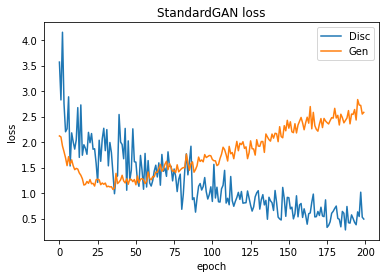

In [ ]:
plt.plot(np.arange(200), d_loss, label='Disc')
plt.plot(np.arange(200), g_loss, label='Gen')
plt.title('StandardGAN loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

In [ ]:
for _ in range(20):
    g_loss = gen_epoch(gen, disc, 100, g_opt, 1)
    print('g_loss ', g_loss)

g_loss  2.5618231123685837
g_loss  2.7419997550547124
g_loss  2.5490299391746523
g_loss  2.67450823277235
g_loss  2.5169640654325485
g_loss  2.8442859017848967
g_loss  2.571974720656872
g_loss  2.5500968390703203
g_loss  2.8934060518443583
g_loss  3.030376824736595
g_loss  2.5590519079566003
g_loss  2.7048915794491766
g_loss  2.6944807422161103
g_loss  2.493582146465778
g_loss  2.5959067395329476
g_loss  2.8439216381311416
g_loss  2.4861677145957946
g_loss  2.6356028711795805
g_loss  2.453610632568598
g_loss  2.6929381200671196


In [ ]:
calc_perpl(gen.gpt)

100%|██████████| 21053/21053 [07:46<00:00, 45.15it/s]


(tensor(inf, device='cuda:0'), tensor(104.5353, device='cuda:0'))

In [ ]:
model3 = torch.load('generation/rularge3.pt')

In [ ]:
for param in gen.gpt.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
for param in gen.gpt.parameters():
    print(param.data)
    break

tensor([[-0.0233,  0.0459, -0.0190,  ...,  0.0442, -0.0333, -0.0033],
        [-0.0631, -0.0645,  0.1472,  ...,  0.0273,  0.1054, -0.0349],
        [-0.0100,  0.0716, -0.0345,  ..., -0.0239, -0.0750, -0.0330],
        ...,
        [ 0.0070, -0.0090, -0.0237,  ...,  0.0675,  0.0057, -0.0070],
        [-0.0172, -0.0506, -0.0135,  ...,  0.0241,  0.0113,  0.0110],
        [ 0.0061,  0.0012,  0.0101,  ...,  0.0263,  0.0305, -0.0131]],
       device='cuda:0')


In [ ]:
generate('Женщина отличается', gen.gpt, tokenizer)

'Женщина отличается от мужчины тем, что она не знает, как себя вести.'

<function matplotlib.pyplot.show(close=None, block=None)>

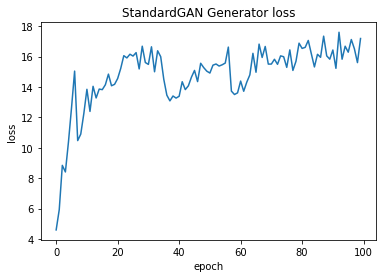

In [ ]:
plt.plot(np.arange(100), g_loss)
plt.title('StandardGAN Generator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

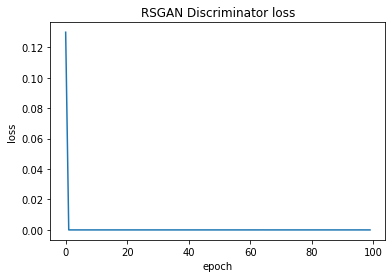

In [ ]:
plt.plot(np.arange(100), d_loss)
plt.title('RSGAN Discriminator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

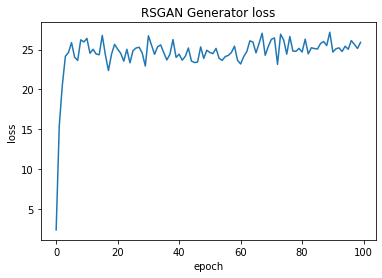

In [ ]:
plt.plot(np.arange(100), g_loss)
plt.title('RSGAN Generator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show

In [ ]:
a = disc(gen_samples(gen, 1, train_data).cuda())
a

tensor([415.1200], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [ ]:
b = disc(sample_from_train(1, train_data).cuda())
b

tensor([1570.0780], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [ ]:
get_losses(b,a, 'rsgan')

(tensor(1154.9580, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 tensor(0., device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [ ]:
gen_samples(gen, 1, train_data)

tensor([[[8.9392e-11, 2.0842e-10, 3.8129e-10,  ..., 5.8695e-23,
          7.8576e-10, 2.4181e-10],
         [4.5896e-10, 1.2700e-09, 2.2628e-10,  ..., 8.4653e-15,
          3.0821e-09, 2.1738e-10],
         [2.2369e-11, 1.3934e-10, 5.7976e-10,  ..., 6.0297e-20,
          9.8579e-11, 1.8312e-10],
         ...,
         [7.4285e-11, 8.4282e-10, 3.0195e-11,  ..., 5.2031e-16,
          7.8374e-11, 9.8340e-11],
         [1.2672e-09, 2.2682e-08, 3.5560e-09,  ..., 6.8497e-16,
          2.4035e-09, 5.5846e-10],
         [1.0859e-05, 1.2594e-05, 7.9321e-07,  ..., 8.1047e-08,
          9.7532e-01, 1.4245e-07]]])